`This report is part of the interview process at Oslo Metropolitan University in Norway`

In this report, we will use machine learning models for classification lower back pain. The task is to classify whether each data sample is normal or abnormal based of a set of features. The number of features in the dataset is 12. The dataset is taken from the website [Kaggle website](https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset)). The dataset contains 310 data samples.

In this report, we will go through

- Using Machine Learning models
  - Logistic Regression.
  - Decision Trees.
  - Random Forest.
  - Support Vector Machine
  - Artifical Neural Networks
- Explaining the predictions
  - SHAP.
  - Interpret.
- Hyperparameter Optimization 
  - Grid Search.

## 1. Import Packages

We'll first import all the common packages that we need for this assignment. 

- `shap` is a library that explains predictions made by machine learning models.
- `interpret` is a library that explains predictions made by machine learning models.
- `lime` is a library that explains predictions made by machine learning models.
- `pytorch` is a Framework for building neural networks architectures.
- `sklearn` is machine learning library 
- `numpy` is a Python scientific computing package.
- `math` is a python module for mathimatical functions
- `scipy` is a Python scientific computing package.
- `pandas` is used for data wrangling
- `seaborn` is a plotting and visualizing library
- `matplotlib` is a plotting library.

In [68]:
import shap
from interpret import show
from interpret.blackbox import LimeTabular
from interpret.glassbox import ClassificationTree
from interpret.glassbox import LogisticRegression as LogReg

import torch
from torch import nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import math
from scipy.stats import zscore

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score 
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from IPython.display import clear_output

## 2. Reading Dataset

We use pandas library to read csv file. The columns names are stored in the last column in the dataframe which is named "Unnamed: 13". The dataset contains 12 features shown in columns and label column. 

The features are: 
- `pelvic_incidence`
- `pelvic_tilt`
- `lumbar_lordosis_angle`
- `sacral_slope`
- `pelvic_radius`
- `degree_spondylolisthesis`
- `Direct_tilt`
- `scoliosis_slope`
- `cervical_tilt`
- `sacrum_angle`
- `pelvic_slope`
- `thoracic_slope`

In [61]:
df = pd.read_csv('./data/Dataset_spine.csv')

# get column names for better visualization
column_names = list(df['Unnamed: 13'])[5:17]
column_names = [col.split("=")[1].strip().replace(
    '(numeric)', '').strip() for col in column_names]
column_names.append('labels')

## 3. Exploratory Data Analysis

We notice from the statistics of the data that the maximum value of the feature degree_spondylolisthesis is 418.5 which is extremely far from the 75 percentile (41.28). This simply means that this data point could be an extreme outlier and it could be an error in measurement.  

In [62]:
labels = df['Class_att']
y = [1 if label == 'Abnormal' else 0 for label in labels]
df['Class_att'] = y
df = df.drop(['Unnamed: 13'], axis=1)
df.columns = column_names
df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,labels
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,0.472979,21.321526,13.064511,11.933317,-14.053139,25.645981,0.677419
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,0.285787,8.639423,3.399713,2.893265,12.225582,10.450558,0.468220
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900,0.000000
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,0.224367,13.054400,10.417800,9.541140,-24.289522,17.189075,0.000000
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,0.475989,21.907150,12.938450,11.953835,-14.622856,24.931950,1.000000
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,0.704846,28.954075,15.889525,14.371810,-3.497094,33.979600,1.000000
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200,1.000000


We visualize the data using boxplot. We notice there is one extreme outlier in the degree_spondylolisthesis feature. So, we decided to remove this outlier. This outlier can be removed manually or using any outlier detection. This extreme outlier seems to be error in measurements and can be corrected by replacing it with average of the feature.

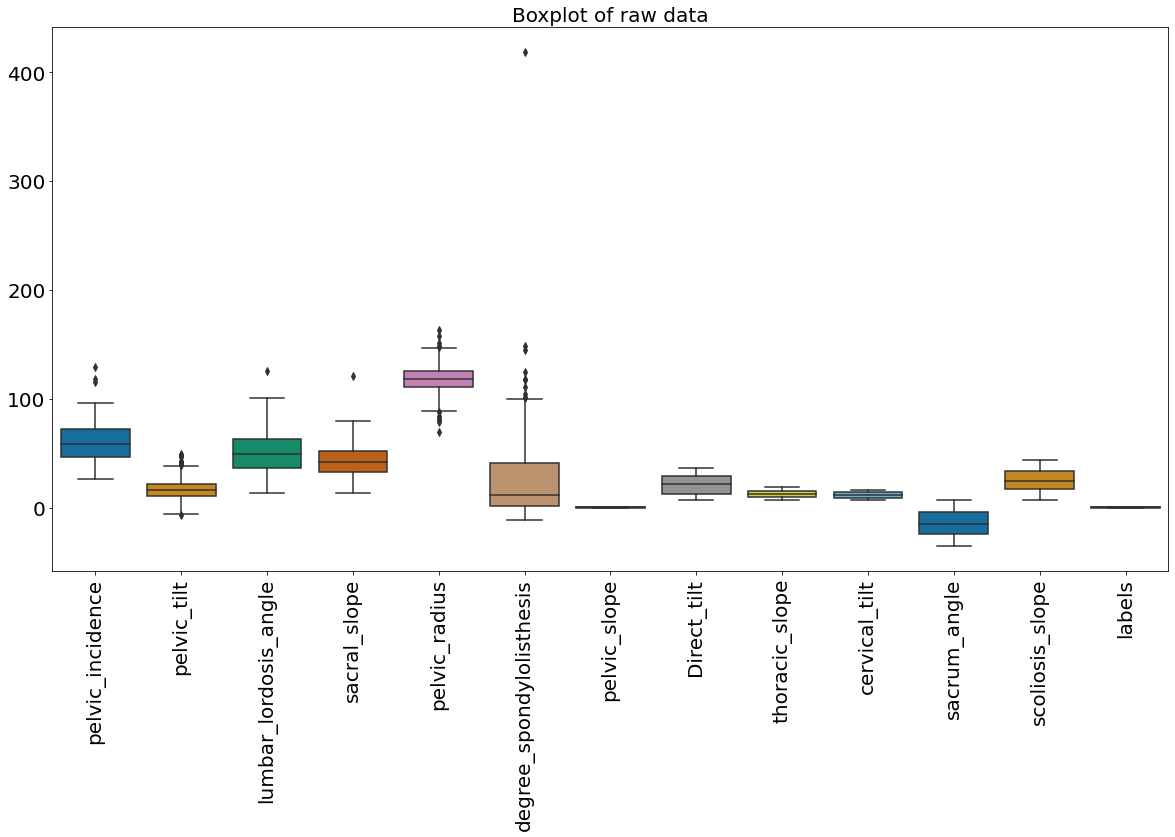

In [63]:
plt.figure(figsize=(20, 10))
plt.title('Boxplot of raw data', fontsize=20)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
sns.boxplot(data=df, palette="colorblind")
plt.show()

In these methods, We used z-score to detect outliers.

In [64]:
def z_score(df):
    """
    Application of zscore filtering on raw data to remove outliers
    """
    clean_df = df
    for col in df.columns:
        z_scores = zscore(clean_df[[col]])
        abs_z_scores = np.abs(z_scores)
        filtered_entries = (abs_z_scores < 10).all(axis=1)
        clean_df = clean_df[filtered_entries]
    return clean_df

df = z_score(df)

The next cell shows the histogram of all the observations (after removing the one extreme data sample). Some features show normal distribution such as pelvic tilt, pelvic_radius and sacral slope. There are still some noticable outliers in pelvic incidence and kumbar lordosis angle. We decided NOT to remove these outliers because this could be losing valuable data samples given the samell size of the entire dataset.   

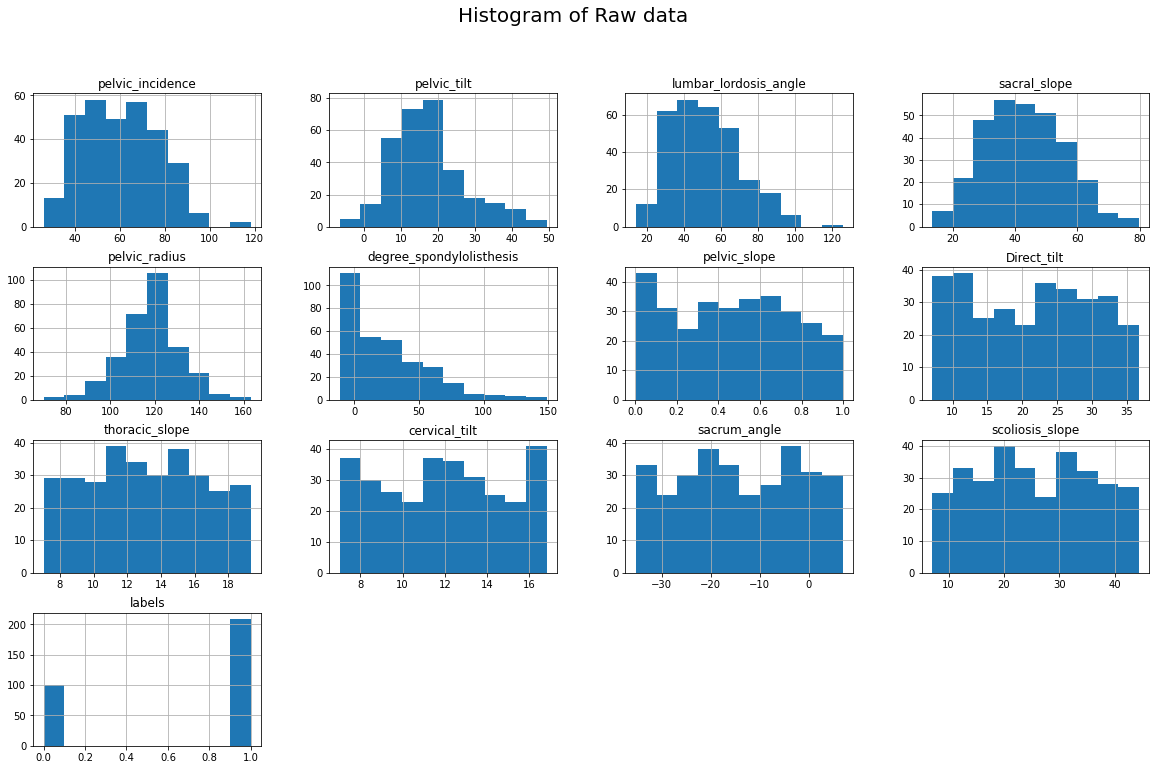

In [65]:
#Histogram of Raw Data
df.hist(figsize=(20, 12))
plt.suptitle('Histogram of Raw data', fontsize=20)
plt.show()

Then, we split the data into train and test subsets. The test data size is 33% of the entire data. We standardize the train data here by each by reducing the mean of the data samples from each data sample and subdivide each data sample by the standard deviation. 

In [66]:
# split the data into and test subsets 
X = df.loc[:, df.columns != 'labels']
y = df.loc[:, df.columns == 'labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=404, stratify=y)
y_train = np.array(y_train).ravel()

# standardize the train and test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert the arrays into dataframe
X_train = pd.DataFrame(X_train)
X_train.columns = column_names[:-1]
X_test = pd.DataFrame(X_test)
X_test.columns = column_names[:-1]

## Models

### Logistic Regression

Logistic regression is based on the logistic function or sigmoid function $f(z) = \frac{1}{1+e^{-z}}$. This function leads to squeezing the values from (-infinity, +infinity) to values in between (0, 1) which represents probability. The earlier mentioned $z$ is a combination of the features multiplied by weights.$z=b1*x1+b2*x2+...+a$ where $b1, b2..., a$ are coefficients and $x1, x2..$ are the feature values. The weights can be learned using learning algorithm (Gradient algorithm such as LBFGS) to optimize the loss function (Log Loss). 

In [9]:
logReg = LogisticRegression(random_state=404, solver='lbfgs')
logReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=404, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The recorded evaluation matrics are **accuracy**, **f1**, **precision** and **recall** to quantify the amount of true positive and true negatives in the predictions.

$P = \frac {TP}{TP+FP} $

$R = \frac {TP}{TP+FN} $

$Acc = \frac {TP+TN}{TP+TN+FP+FN} $

$f1 = \frac {2P*R}{P+R} $


There are three types of evaluation metrics: **Macro**, **Micro** and **Weighted**. **Weighted** average F1, Precision and Recall scores can also be measured as arithmetic mean of all the measured F1, Precision and Recall scores for each class weighted by the number of support of that class. **Micro** averaged F1, Precision and Recall are calculated using the total TP by looking at all the samples together. For example, **micro** Precision counts the total number of TP and FP in the entire data before calculating the measure. For **macro** Precision, TP and FP are counted and the measure is calculated for each class before taking arithmetic mean. If the data is balanced, macro and micro measures will show identical results.

In [10]:
y_hat = logReg.predict(X_test)
print('Accuracy: ', logReg.score(X_test, y_test))
print('Macro F1 Score: ', f1_score(y_test,y_hat, average='macro'))
print('Macro Precision Score: ', precision_score(y_test,y_hat, average='macro'))
print('Macro Recall Score: ', recall_score(y_test,y_hat, average='macro'))

Accuracy:  0.8627450980392157
Macro F1 Score:  0.840625
Macro Precision Score:  0.8468877782825988
Macro Recall Score:  0.8353096179183135


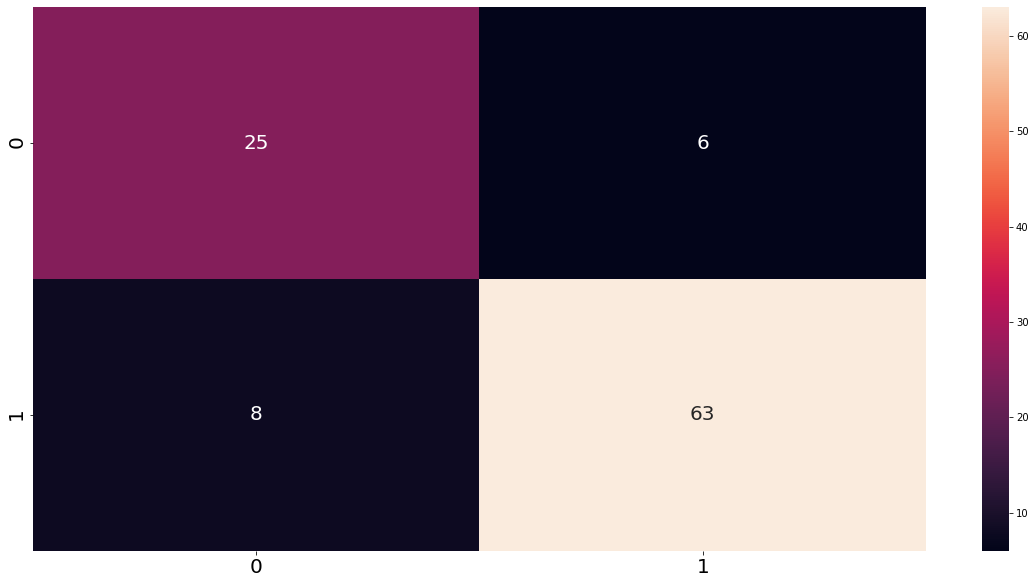

In [11]:
def conf_plot(y_hat, y_test):
    plt.figure(figsize=(20, 10))
    sns.heatmap(confusion_matrix(y_hat, y_test), annot=True, annot_kws={"size":20})
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    
conf_plot(y_hat, y_test)

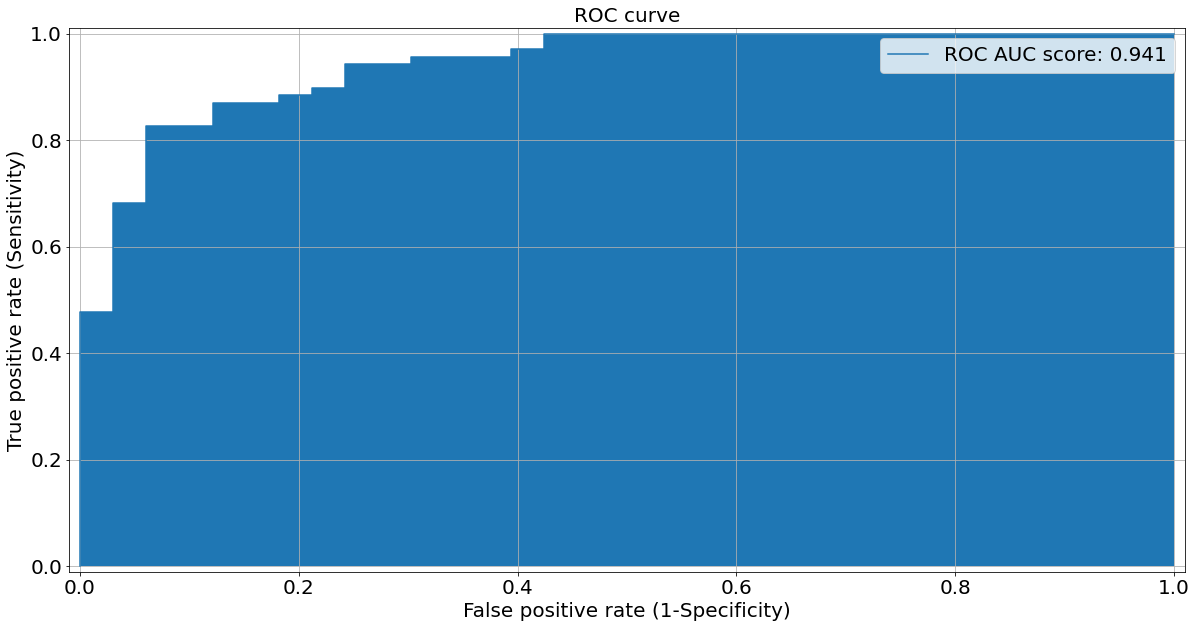

In [12]:
def roc_curve_plot(model, x, y):
    plt.figure(figsize=(20, 10))
    
    y_pred=model.predict_proba(x)[:,:]
    auc_score = roc_auc_score(y,y_pred[:,1])    

    fpr, tpr, thresholds = roc_curve(y, y_pred[:, 1])
    plt.plot(fpr,tpr, label="ROC AUC score: "+str(auc_score)[:5])
    plt.fill_between(fpr,tpr)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('ROC curve', fontsize=20)
    plt.xlabel('False positive rate (1-Specificity)', fontsize=20)
    plt.ylabel('True positive rate (Sensitivity)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)
    plt.show()
    
roc_curve_plot(logReg, X_test, y_test)

In [13]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78        33
           1       0.89      0.91      0.90        69

    accuracy                           0.86       102
   macro avg       0.85      0.84      0.84       102
weighted avg       0.86      0.86      0.86       102



In [14]:
explainer = shap.LinearExplainer(logReg, X_train)
shap_values = explainer(X_test)

The next waterfall plot are displays explanations for individual predictions. The x axis of a waterfall is the expected vallogRegf the model output. Each row shows how the positive (reLogisticRegressionor negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

In [15]:
shap_values[1, :]

.values =
array([-8.66197285e-02,  5.02610751e-01, -5.35369021e-03, -5.88507020e-02,
        1.40230936e+00, -1.66542896e+00, -1.03351214e-02, -1.67536428e-02,
       -1.27833857e-03, -3.78235052e-02,  4.49508471e-02,  1.46773167e-01])

.base_values =
2.3168803139679626

.data =
array([ 0.55138809,  0.66929468, -0.38186593,  0.19850303, -1.28157393,
       -0.43436577, -0.38162303,  0.31796379, -0.03438935, -0.23226504,
       -1.35280097, -0.68759723])

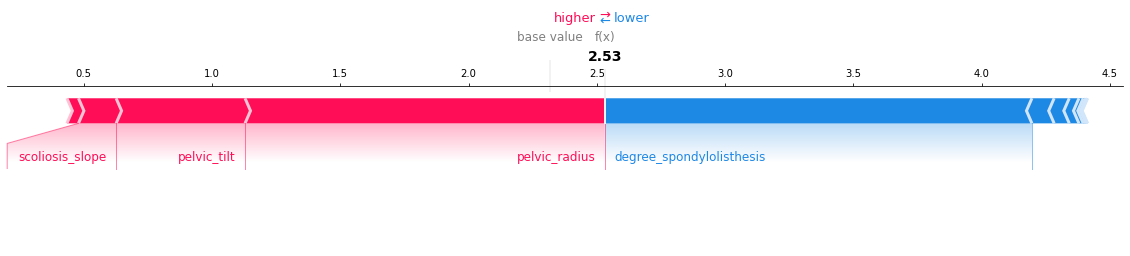

In [16]:
shap.force_plot(shap_values[1, :].base_values, shap_values[1, :].values, feature_names=column_names[:-1], matplotlib=True)

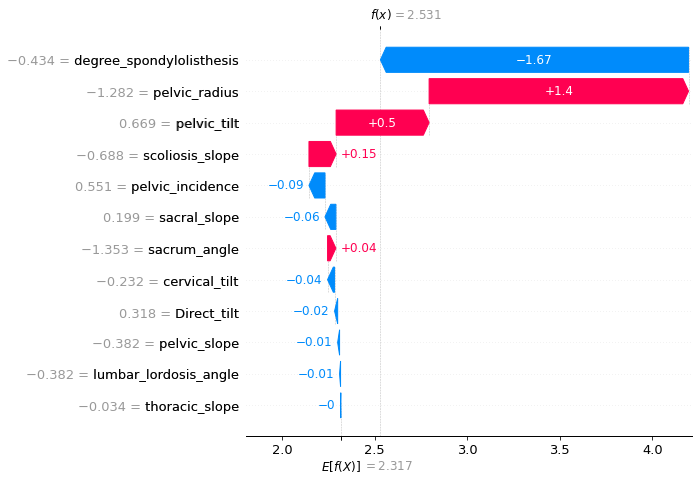

In [17]:
shap.plots.waterfall(shap_values[1], max_display=12)

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. Each instance the given explanation is represented by a single dot on each feature fow. The x position of the dot is determined by the SHAP value (shap_values.value[instance,feature]) of that feature, and dots “pile up” along each feature row to show density. Color is used to display the original value of a feature (shap_values.data[instance,feature]). In the plot below we can see that Age is the most important feature on average, and than young (blue) people are less likely to make over \$50k.

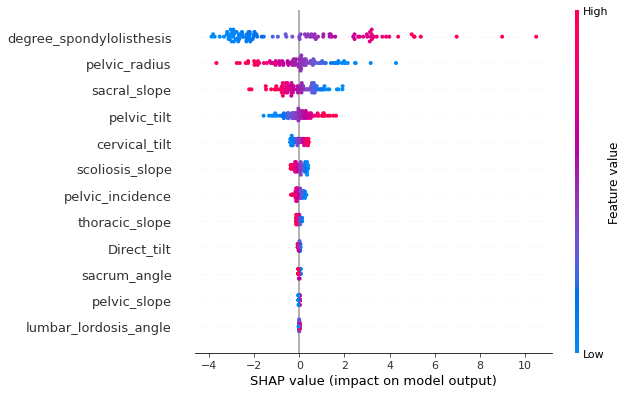

In [18]:
shap.plots.beeswarm(shap_values, max_display=12)

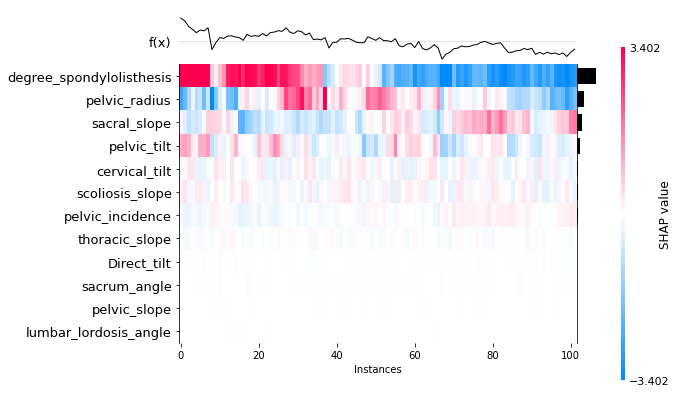

In [19]:
shap.plots.heatmap(shap_values, max_display=12)

In [22]:
lime = LimeTabular(predict_fn=logReg.predict_proba, data=X_train, random_state=404)
lime_local = lime.explain_local(X_test[:10], y_test[:10])
show(lime_local)


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


<!-- http://127.0.0.1:7001/140201920898512/ -->

### Decision Tree

In [23]:
dt = DecisionTreeClassifier(max_depth=100, random_state=10)
print(dt)

from sklearn.model_selection import GridSearchCV

parameteres = {'max_depth': np.arange(1,100,10),
               'criterion': ['gini', 'entropy']}

grid_dt = GridSearchCV(dt, param_grid=parameteres, cv=StratifiedKFold(n_splits=5), iid = 'True')

grid_dt.fit(X_train, y_train)
print('Best Score: ', grid_dt.best_score_)
print('Best Params: ', grid_dt.best_params_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')
Best Score:  0.782608695652174
Best Params:  {'criterion': 'entropy', 'max_depth': 11}


In [24]:
dt = DecisionTreeClassifier(**grid_dt.best_params_)
dt.fit(X_train, y_train)
y_hat = dt.predict(X_test)
print('Accuracy: ', dt.score(X_test, y_test))
print('Macro F1 Score: ', f1_score(y_test,y_hat, average='macro'))
print('Macro Precision Score: ', precision_score(y_test,y_hat, average='macro'))
print('Macro Recall Score: ', recall_score(y_test,y_hat, average='macro'))

Accuracy:  0.7941176470588235
Macro F1 Score:  0.7629219701162148
Macro Precision Score:  0.7651785714285715
Macro Recall Score:  0.7608695652173914


In [25]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68        33
           1       0.84      0.86      0.85        69

    accuracy                           0.79       102
   macro avg       0.77      0.76      0.76       102
weighted avg       0.79      0.79      0.79       102



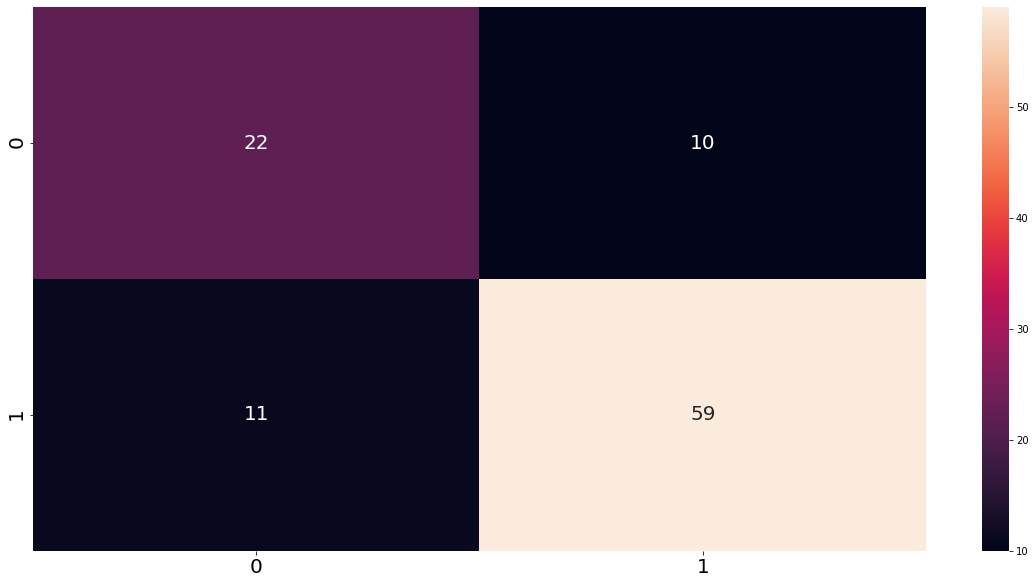

In [26]:
conf_plot(y_hat, y_test)

In [27]:
explainer = shap.TreeExplainer(dt, X_train)
shap_values = explainer(X_test)

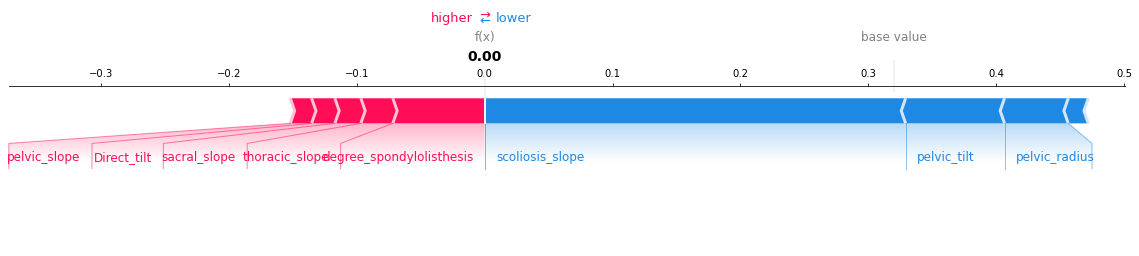

In [28]:
shap.force_plot(shap_values[1, :].base_values[0], shap_values[1, :].values[:, 0], feature_names=column_names[:-1], matplotlib=True)

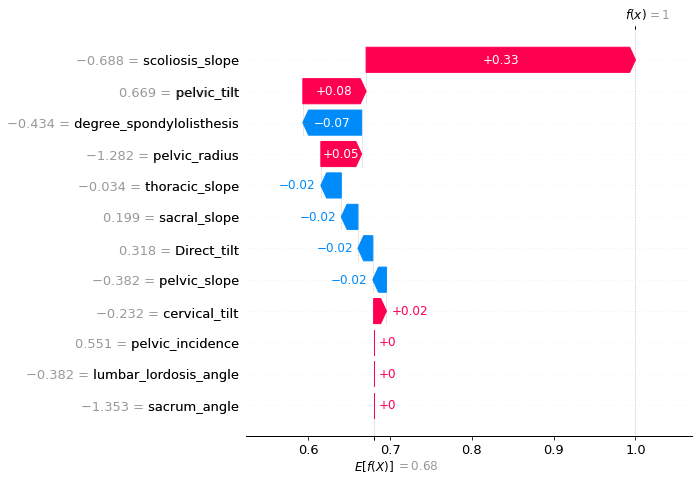

In [29]:
shap.plots.waterfall(shap_values[1, :, 1], max_display=12)

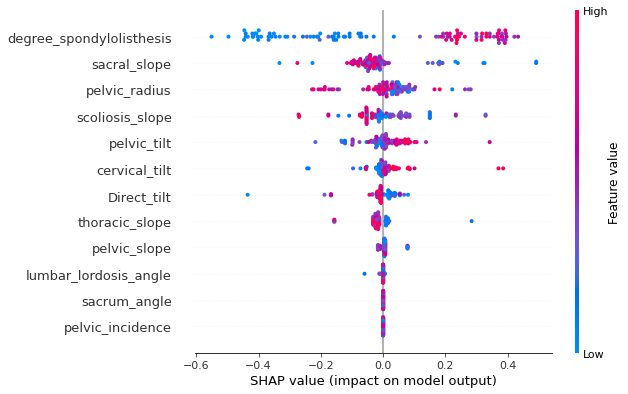

In [30]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=12)

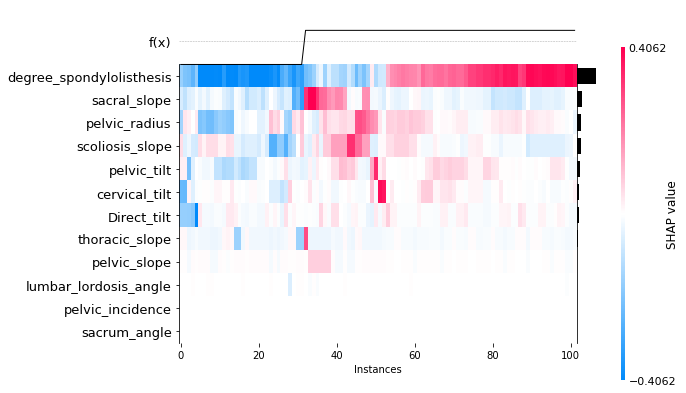

In [31]:
shap.plots.heatmap(shap_values[:, :, 1], max_display=12)

In [32]:
lime = LimeTabular(predict_fn=dt.predict_proba, data=X_train, random_state=404)
lime_local = lime.explain_local(X_test[:10], y_test[:10])
show(lime_local)

<!-- http://127.0.0.1:7001/140201779967632/ -->

In [67]:
edt = ClassificationTree()
edt.fit(X_train, y_train)
edt_local = edt.explain_local(X_test[:10], y_test[:10])
show(edt_local)

<!-- http://127.0.0.1:7001/140201624446480/ -->

### Random Forest

In [33]:
# build random forest classsifier
rf = RandomForestClassifier(n_estimators=100, random_state=10)

# Grid Search for random forest
parameteres = {'max_depth': np.arange(1,11,1),
               'criterion': ['gini', 'entropy'],
               'n_estimators':np.arange(100, 500, 50)}
grid_rf = GridSearchCV(rf, param_grid=parameteres, cv=StratifiedKFold(n_splits=5), iid = 'True')
grid_rf.fit(X_train, y_train)
print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.821256038647343
{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 250}


In [34]:
rf = RandomForestClassifier(**grid_rf.best_params_)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)
print('Accuracy: ', rf.score(X_test, y_test))
print('Macro F1 Score: ', f1_score(y_test,y_hat, average='macro'))
print('Macro Precision Score: ', precision_score(y_test,y_hat, average='macro'))
print('Macro Recall Score: ', recall_score(y_test,y_hat, average='macro'))

Accuracy:  0.8823529411764706
Macro F1 Score:  0.8633928571428572
Macro Precision Score:  0.8700590640617901
Macro Recall Score:  0.8577075098814229


In [35]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81        33
           1       0.90      0.93      0.91        69

    accuracy                           0.88       102
   macro avg       0.87      0.86      0.86       102
weighted avg       0.88      0.88      0.88       102



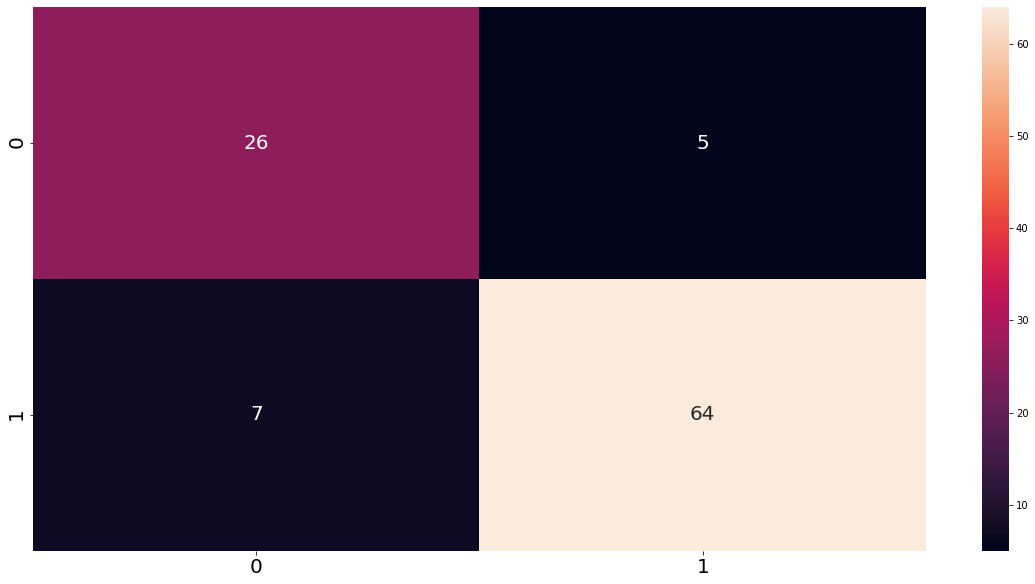

In [36]:
conf_plot(y_hat, y_test)

In [37]:
explainer = shap.TreeExplainer(rf, X_train)
shap_values = explainer(X_test)

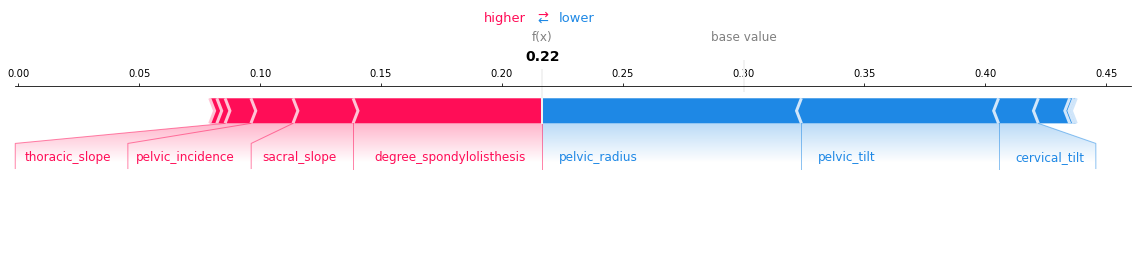

In [38]:
shap.force_plot(shap_values[1, :].base_values[0], shap_values[1, :].values[:, 0], feature_names=column_names[:-1], matplotlib=True)

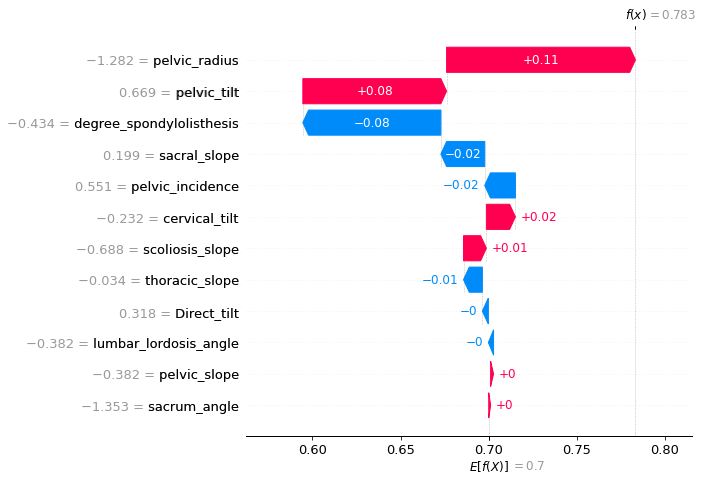

In [39]:
shap.plots.waterfall(shap_values[1, :, 1], max_display=12)

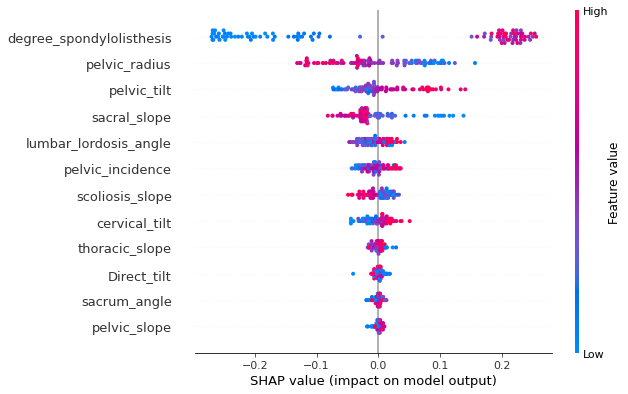

In [40]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=12)

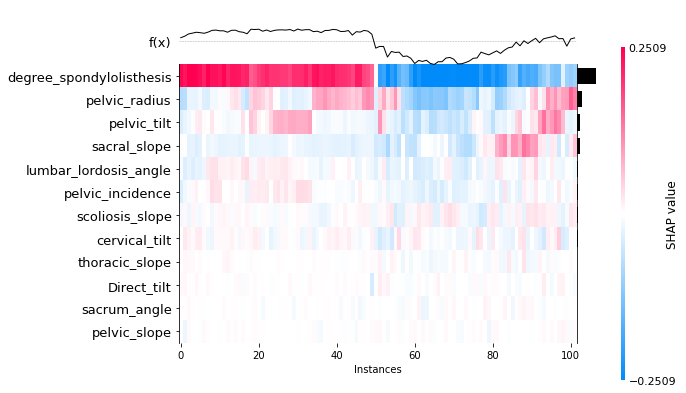

In [41]:
shap.plots.heatmap(shap_values[:, :, 1], max_display=12)

In [42]:
lime = LimeTabular(predict_fn=rf.predict_proba, data=X_train, random_state=404)
lime_local = lime.explain_local(X_test[:10], y_test[:10])
show(lime_local)

<!-- http://127.0.0.1:7001/140201778186896/ -->

### SVM

In [43]:
svm = SVC(gamma='auto')

# Grid Search for random forest
parameteres = {'gamma': ['scale', 'auto'],
               'C': np.arange(1, 10, 1),
               'degree': np.arange(1, 5, 1),
               'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
grid_svm = GridSearchCV(svm, param_grid=parameteres, cv=StratifiedKFold(n_splits=5), iid = 'True')
grid_svm.fit(X_train, y_train)
print(grid_svm.best_score_)
print(grid_svm.best_params_)

0.8502415458937198
{'C': 4, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}


In [44]:
svm = SVC(**grid_svm.best_params_)
svm.fit(X_train, y_train)
y_hat = svm.predict(X_test)
print('Accuracy: ', svm.score(X_test, y_test))
print('Macro F1 Score: ', f1_score(y_test,y_hat, average='macro'))
print('Macro Precision Score: ', precision_score(y_test,y_hat, average='macro'))
print('Macro Recall Score: ', recall_score(y_test,y_hat, average='macro'))

Accuracy:  0.8627450980392157
Macro F1 Score:  0.840625
Macro Precision Score:  0.8468877782825988
Macro Recall Score:  0.8353096179183135


In [45]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78        33
           1       0.89      0.91      0.90        69

    accuracy                           0.86       102
   macro avg       0.85      0.84      0.84       102
weighted avg       0.86      0.86      0.86       102



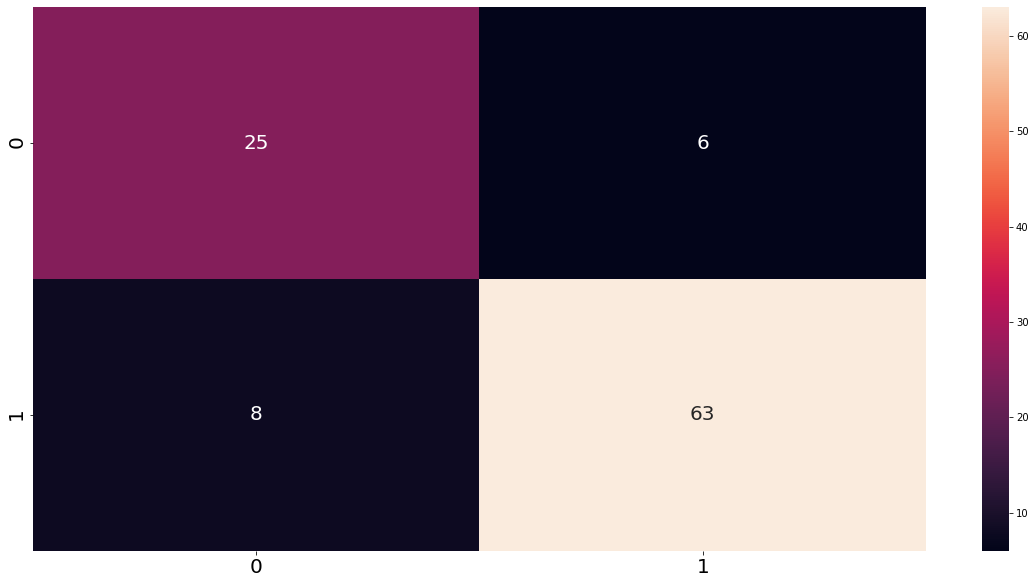

In [46]:
conf_plot(y_hat, y_test)

### ANN

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(12, 128),
            nn.Linear(128, 128),
            nn.Linear(128, 1) 
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

In [49]:
y_test= np.array(y_test)
y_train= np.array(y_train)
X_test = np.array(X_test)
X_train = np.array(X_train)

In [50]:
batch_size=32
xtest = torch.Tensor(X_test).to(device)
ytest = torch.Tensor(y_test).to(device)
test_data = torch.utils.data.TensorDataset(xtest, ytest)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

In [51]:
def build_kfold_dataloader(Xtrain, ytrain, xval, yval):
    
    batch_size=32
    
    xtrain = torch.Tensor(Xtrain).to(device)
    ytrain = torch.Tensor(ytrain).to(device)
    xval = torch.Tensor(xval).to(device)
    yval = torch.Tensor(yval).to(device)   
    train_data = torch.utils.data.TensorDataset(xtrain, ytrain)
    val_data = torch.utils.data.TensorDataset(xval, yval)    
    train_iter = torch.utils.data.DataLoader(train_data, batch_size)
    val_iter = torch.utils.data.DataLoader(val_data, batch_size)
    
    return train_iter, val_iter 

In [52]:
def evaluate(data_iter):
    model.eval()
    preds = []
    trues = []
    running_loss = 0.0
    for i, data in enumerate(data_iter, 0):
        #inputs, labels = data
        
        inputs, labels = data
        outputs = model(inputs)
        labels = labels.float()
        outputs = outputs.squeeze()
        labels = labels.squeeze()
        loss = BCE(outputs, labels)
        outputs = outputs.cpu().detach().numpy().reshape(-1)
        true = labels.cpu().detach().numpy().reshape(-1)
        outputs = list(outputs)
        true = list(true)
        outputs = [1 if i>=0.5 else 0 for i in outputs]
        true = [1 if i>=0.5 else 0 for i in true]
        preds.extend(outputs)
        trues.extend(true)
        running_loss += loss.item()
    return f1_score(preds, trues), running_loss

In [53]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

X_train = np.array(X_train)
y_train = np.array(y_train)

train_f1_values = []
val_f1_values = []
for train_index, val_index in kf.split(X_train):
    Xtrain, Xval = X_train[train_index], X_train[val_index]
    ytrain, yval = y_train[train_index], y_train[val_index]
    train_iter, val_iter  = build_kfold_dataloader(Xtrain, ytrain, Xval, yval)
    model = NeuralNetwork().to(device)    
    BCE = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    
    model.train()
    
    train_f1 = []
    val_f1 = []
    for epoch in range(100):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_iter, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.float()
            outputs = outputs.squeeze()
            labels = labels.squeeze()
            loss = BCE(outputs, labels)
            loss.backward()
            optimizer.step()
        running_loss += loss.item()
     
        train_f1.append(evaluate(train_iter)[0])
        val_f1.append(evaluate(val_iter)[0])
        if epoch%10 == 0:
            print('Epoch: ', epoch+1)
            print('Train Loss: ', running_loss, ', Val Loss: ', evaluate(val_iter)[1])
            print('Train Accuracy: ', evaluate(train_iter)[0], ', Val Accuracy: ', evaluate(val_iter)[0])
            
    train_f1_values.append(train_f1)
    val_f1_values.append(val_f1)
    
clear_output()

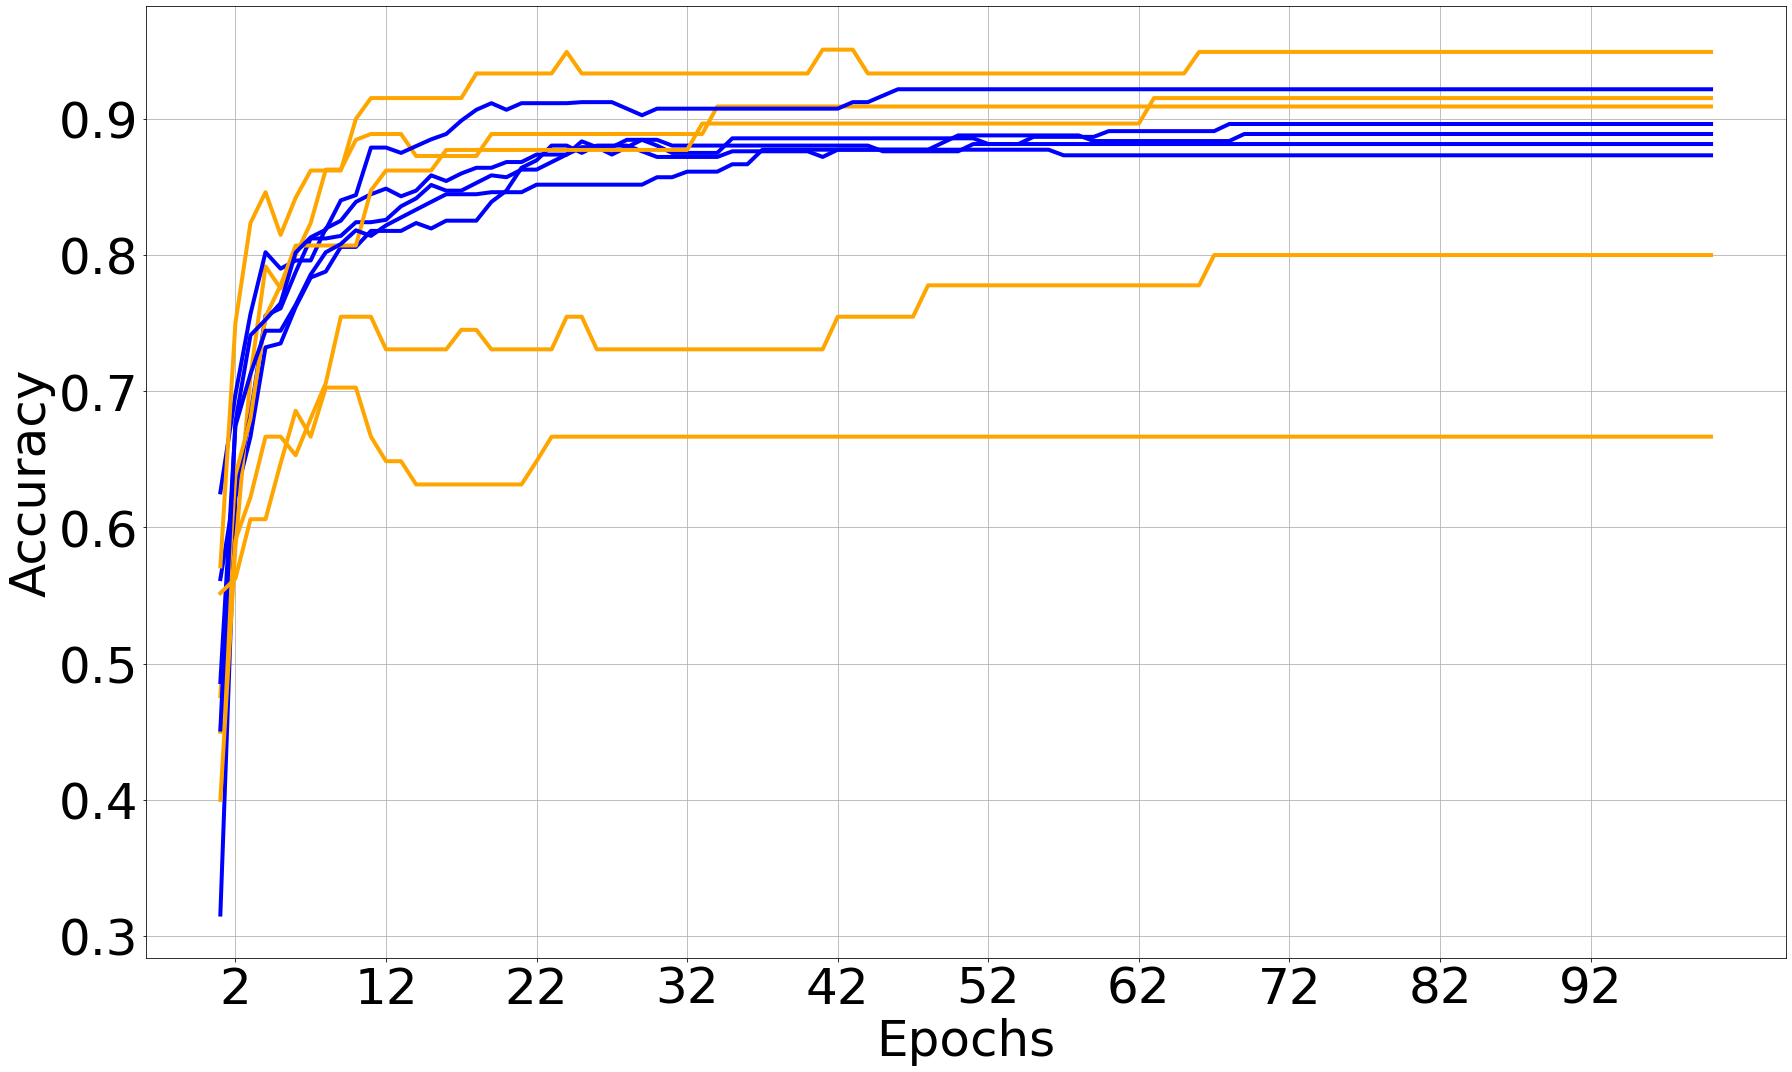

In [54]:
val_f1_values = np.array(val_f1_values)
train_f1_values = np.array(train_f1_values)

def make_plot():
    epochs = range(1, 101)
    xint = range(min(epochs)+1, math.ceil(max(epochs))+1, 10)

    colors = ["#0000FF", "#FFA500"]
    plt.figure(figsize=(25,15))
    for i in range(len(val_f1_values)):
        plt.plot(epochs, train_f1_values[i], linewidth=4, c="#0000FF")
        plt.plot(epochs, val_f1_values[i], linewidth=4, c="#FFA500")
    plt.xlabel('Epochs', fontsize=50)
    plt.ylabel('Accuracy', fontsize=50)
    #plt.legend(fontsize=50)
    plt.xticks(xint, fontsize=50)
    plt.yticks(fontsize=50)
    plt.grid()
    plt.tight_layout()
    plt.show()

make_plot()

In [55]:
X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train).to(device)
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size)
    
final_model = NeuralNetwork().to(device)    
BCE = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.05)
    
model.train()
    
train_f1 = []
val_f1 = []
for epoch in range(40):
    running_loss = 0.0
    for i, data in enumerate(train_iter, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = final_model(inputs)
        outputs = outputs.squeeze()
        labels = labels.float()
        outputs = outputs.squeeze()
        labels = labels.squeeze()
        loss = BCE(outputs, labels)
        loss.backward()
        optimizer.step()
    running_loss += loss.item()

In [56]:
final_model.eval()

preds = []
for i, data in enumerate(test_iter, 0):
    inputs, labels = data
    y_hat = final_model(inputs)
    y_hat = y_hat.cpu().detach().numpy().reshape(-1)
    y_hat = list(y_hat)
    preds.extend(y_hat)
    #print(y_hat)
preds = np.array(preds).flatten()
y_hat = [1 if i>=0.5 else 0 for i in preds]
y_hat = np.array(y_hat)

print('Accuracy: ', accuracy_score(y_test, y_hat))
print('Macro F1 Score: ', f1_score(y_test,y_hat, average='macro'))
print('Macro Precision Score: ', precision_score(y_test,y_hat, average='macro'))
print('Macro Recall Score: ', recall_score(y_test,y_hat, average='macro'))

Accuracy:  0.8627450980392157
Macro F1 Score:  0.8455882352941178
Macro Precision Score:  0.8409381663113007
Macro Recall Score:  0.8511198945981555


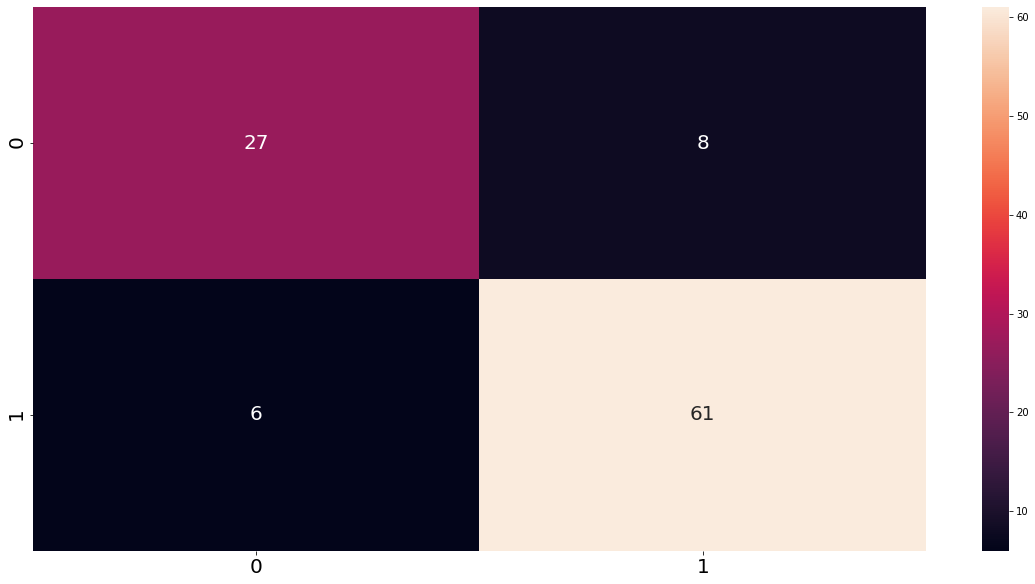

In [57]:
conf_plot(y_hat, y_test)